### Description

### load 

In [4]:
import os
import random 
import pickle
import sys
import pandas as pd
import numpy as np

root_path = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
# to import src is necessary to append the root_path to the path
#sys.path.append(root_path)

data_path = os.path.join(root_path,'data')
results_path = os.path.join(root_path,'results')

### Define global variables

In [5]:
WITH_STEMMING = True
REMOVE_STOPWORDS = True
MINIMUM_WORDS_PER_PHRASE = 0
GROUP = -1
SEED = 10
num_topics = 60
random.seed(SEED)

### split dataset

In [8]:
lessons_filename = 'clean_inquiry_phrases_by_phase_{}_{}_GROUP_{}_min_{}.pickle'.format(REMOVE_STOPWORDS,WITH_STEMMING,GROUP,MINIMUM_WORDS_PER_PHRASE)
with open(os.path.join(data_path,lessons_filename),'rb') as f:
    clean_phrases = pickle.load(f)

In [4]:
for key in clean_phrases:
    n = len(clean_phrases[key])
    print("key {}, total {}".format(key,n))

key 1, total 479
key 3, total 483
key 5, total 663
key 2, total 210
key 4, total 70


In [5]:
len(clean_phrases[2])

210

In [6]:
def split_sets(dataset,train=False):
    trainset = {}
    testset = {}
    for key in dataset:
        if len(dataset[key])>0 and key!=11:
            trainset[key]=[]
            testset[key]=[]
            n = len(dataset[key])
            ra = random.sample(range(1,n),int(n*0.2))
            for i in range(n):
                if i in ra:
                    testset[key].append(clean_phrases[key][i])
                else:
                    trainset[key].append(clean_phrases[key][i])                
    return trainset,testset

In [7]:
trainset,testset = split_sets(clean_phrases)

In [8]:
len(trainset)

5

### get topic distribution to test set and trainset

In [9]:
a_name = 'lda_textbooks_chunksize_alpha_auto_seed_{}_{}_{}_{}.pickle'.format(SEED,num_topics,REMOVE_STOPWORDS,WITH_STEMMING)
model_file = os.path.join(results_path,'lda_models',a_name)
with open(model_file,'rb') as f:
    ldamodel = pickle.load(f)

C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [10]:
dict_file = os.path.join(data_path,'dictionary_seed_{}_{}_{}_{}.pickle'.format(SEED,num_topics,REMOVE_STOPWORDS,WITH_STEMMING))
with open(dict_file,'rb') as f:
    dictionary = pickle.load(f)
print("Dictionary length removing unfrequent words: {}".format(len(dictionary)))

Dictionary length removing unfrequent words: 14809


In [11]:
def get_topic_distribution(a_set):
    y = []
    X = []
    for key in a_set:
        for a_lesson in a_set[key]:
            bow = dictionary.doc2bow(a_lesson.split())
            T = ldamodel.get_document_topics(bow,minimum_probability=0,minimum_phi_value=0.001)
            X.append([x[1] for x in T])
            y.append(key)
    return X,y

In [12]:
X_train,y_train = get_topic_distribution(trainset)
X_test,y_test = get_topic_distribution(testset)

In [13]:
def get_topic_distribution_phrase(a_set):
    y = []
    X = []
    z = []
    w = []
    for key in a_set:
        for a_lesson in a_set[key]:
            bow = dictionary.doc2bow(a_lesson.split())
            T = ldamodel.get_document_topics(bow,minimum_probability=0,minimum_phi_value=0.001)
            X.append([x[1] for x in T])
            y.append(key)
            z.append(a_lesson)
            w.append(len(a_lesson.split()))
    return X,y,z,w

In [14]:
X,y,z,w = get_topic_distribution_phrase(clean_phrases)

In [27]:
df = pd.DataFrame(X,columns=list(map(lambda x:'Topic {}'.format(x+1),range(num_topics))))
df['phase'] = y
df['phase_1'] = list(map(lambda x: 1 if x==1 else 0,y))
df['phase_2'] = list(map(lambda x: 1 if x==2 else 0,y))
df['phase_3'] = list(map(lambda x: 1 if x==3 else 0,y))
df['phase_4'] = list(map(lambda x: 1 if x==4 else 0,y))
df['phase_5'] = list(map(lambda x: 1 if x==5 else 0,y))
df['utterance'] = z
df['length utterance']=w
print(len(df))
df.head()


1905


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 59,Topic 60,phase,phase_1,phase_2,phase_3,phase_4,phase_5,utterance,length utterance
0,0.011022,0.014644,0.007331,0.006667,0.004254,0.005783,0.005424,0.010022,0.014657,0.018260,...,0.013978,0.013502,1,1,0,0,0,0,satunnaiskävely,1
1,0.005717,0.007596,0.003803,0.003458,0.002207,0.003000,0.002814,0.005199,0.007604,0.009472,...,0.007251,0.007004,1,1,0,0,0,0,mi ssä vaelt siel QUESTION_SYMBOL onks oo palo,8
2,0.102352,0.009047,0.004529,0.004119,0.002628,0.003573,0.003351,0.006192,0.009055,0.011302,...,0.008636,0.008342,1,1,0,0,0,0,jee no tää varm muutu,5
3,0.005717,0.007596,0.003803,0.077555,0.002207,0.003000,0.002814,0.005199,0.007603,0.009472,...,0.007251,0.007004,1,1,0,0,0,0,aja T_ ATOMI ehtiny törm ton ver,7
4,0.011022,0.014644,0.007331,0.006667,0.004254,0.005783,0.005424,0.010022,0.014657,0.018260,...,0.013978,0.013502,1,1,0,0,0,0,jaaha,1


In [28]:
list(df['length utterance'].values).count(5)

158

In [37]:
writer = pd.ExcelWriter('output.xlsx')

In [30]:
df.to_excel('IBL_topic_distribution_by_utterance_minimum_5_words_with_stemming.xlsx')

### Train decision tree


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = DecisionTreeClassifier().fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.93
Accuracy of Decision Tree classifier on test set: 0.33


In [16]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,max_depth=2,
                         filled=True, rounded=True,  
                         special_characters=True)

In [17]:
graph = graphviz.Source(dot_data) 
graph

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [23]:
clf.predict(X_test)

array([1, 3, 2, 5, 5, 3, 5, 5, 5, 5, 5, 5, 2, 1, 1, 2, 3, 2, 1, 3, 3, 3,
       4, 5, 3, 5, 2, 2, 2, 1, 1, 3, 3, 5, 2, 1, 5, 1, 3, 5, 4, 4, 5, 5,
       1, 2, 5, 2, 5, 5, 1, 1, 5, 5, 1, 1, 5, 3, 5, 3, 1, 1, 3, 2, 5, 1,
       1, 5, 1, 5, 2, 5, 1, 1, 1, 5, 5, 5, 1, 5, 3, 1, 5, 5, 1, 5, 4, 1,
       5, 1, 1, 1, 5, 5, 1, 3, 3, 3, 5, 1, 3, 5, 5, 1, 1, 5, 5, 5, 3, 5,
       1, 3, 3, 2, 3, 3, 3, 5, 2, 3, 5, 5, 3, 5, 5, 5, 1, 3, 3, 3, 1, 3,
       3, 5, 3, 3, 3, 5, 3, 5, 1, 5, 3, 1, 5, 3, 1, 1, 3, 3, 5, 3, 5, 3,
       3, 3, 2, 1, 3, 1, 5, 5, 5, 5, 5, 3, 5, 3, 2, 5, 3, 3, 2, 5, 5, 5,
       1, 3, 1, 3, 3, 5, 2, 5, 5, 5, 5, 3, 5, 3, 1, 3, 2, 5, 3, 5, 5, 1,
       5, 1, 3, 1, 2, 1, 1, 1, 3, 1, 5, 1, 5, 2, 5, 5, 3, 1, 3, 5, 3, 3,
       3, 5, 5, 2, 5, 2, 1, 1, 2, 4, 5, 3, 3, 2, 5, 5, 4, 2, 3, 1, 5, 1,
       1, 3, 5, 1, 1, 1, 1, 2, 5, 5, 5, 4, 3, 5, 5, 1, 1, 2, 5, 1, 5, 1,
       5, 5, 3, 5, 1, 5, 5, 5, 3, 5, 5, 5, 1, 5, 5, 5, 5, 1, 5, 2, 1, 5,
       5, 5, 4, 5, 5, 3, 1, 3, 5, 5, 5, 1, 5, 5, 5,

### Train without stem

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.55
Accuracy of K-NN classifier on test set: 0.36


In [34]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.22
Accuracy of GNB classifier on test set: 0.17


C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


In [78]:
len(X_train)

1526

In [184]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[50 69]
 [37 35]]
              precision    recall  f1-score   support

           0       0.57      0.42      0.49       119
           5       0.34      0.49      0.40        72

   micro avg       0.45      0.45      0.45       191
   macro avg       0.46      0.45      0.44       191
weighted avg       0.48      0.45      0.45       191



In [79]:
X_train

[[0.011021992,
  0.01464388,
  0.007330969,
  0.0066667236,
  0.0042539216,
  0.005782563,
  0.0054240413,
  0.010021971,
  0.01465682,
  0.018260423,
  0.008022386,
  0.00695235,
  0.0070316396,
  0.006192777,
  0.017157245,
  0.017326197,
  0.0075386507,
  0.02429687,
  0.006263032,
  0.009421903,
  0.016132835,
  0.009078798,
  0.015364037,
  0.007393682,
  0.010115208,
  0.009431403,
  0.011923934,
  0.02391742,
  0.0045164,
  0.005170765,
  0.031719163,
  0.013372814,
  0.00832063,
  0.16620362,
  0.011439888,
  0.009881475,
  0.015148245,
  0.007665499,
  0.009352867,
  0.010062565,
  0.008435939,
  0.012740017,
  0.016710129,
  0.06777288,
  0.005471205,
  0.004617979,
  0.009465799,
  0.00936058,
  0.042524602,
  0.00670919,
  0.052400056,
  0.015308765,
  0.0114176655,
  0.009170976,
  0.0055760974,
  0.071176425,
  0.0060525583,
  0.013131635,
  0.013978151,
  0.013501716],
 [0.085928276,
  0.007596,
  0.0038026834,
  0.0034581295,
  0.002206573,
  0.002999502,
  0.0028135316

In [35]:
svm = SVC(decision_function_shape='ovr',gamma=1,C= 100.0)#random_state=SEED,class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.53
Accuracy of SVM classifier on test set: 0.44


In [36]:
svm = SVC(decision_function_shape='ovr',kernel='linear',gamma=1,C= 100.0,random_state=SEED,class_weight={1:0.4,2:0.4,3:0.4,4:0.5,5:0.3})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.45
Accuracy of SVM classifier on test set: 0.44


In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[50  5  8  0 32]
 [14 10  2  1 15]
 [33  2 40  0 21]
 [ 8  1  1  1  3]
 [43 10 15  0 64]]
              precision    recall  f1-score   support

           1       0.34      0.53      0.41        95
           2       0.36      0.24      0.29        42
           3       0.61      0.42      0.49        96
           4       0.50      0.07      0.12        14
           5       0.47      0.48      0.48       132

   micro avg       0.44      0.44      0.44       379
   macro avg       0.46      0.35      0.36       379
weighted avg       0.46      0.44      0.43       379



In [78]:
len(svm.coef_)

10

In [38]:
support_combined=[]
for c in set(y_train[clf.support_]):
    alphas=clf.dual_coef_[0, y_train[clf.support_]==c]
    svs=clf.support_vectors_[y_train[clf.support_]==c]
    support_combined=vstack((support_combined, vstack([alphas.T[i]*svs[i,:]
        for i in range(alphas.shape[1])]).sum(axis=0) ) )

actual_ovr_coef_=support_combined.tocsr()[1:, :]

AttributeError: 'DecisionTreeClassifier' object has no attribute 'support_'

### Train with stem

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.55
Accuracy of K-NN classifier on test set: 0.36


In [40]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.22
Accuracy of GNB classifier on test set: 0.17


#### SVM

In [23]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


The best parameters are {'C': 1000000.0, 'gamma': 1e-05} with a score of 0.42


In [110]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 1000000.0, random_state=42)#random_state=SEED,class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.47
Accuracy of SVM classifier on test set: 0.40


In [111]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 16   5   8   3  63]
 [  3   6   1   2  30]
 [  9   0  30   0  57]
 [  3   0   1   0  10]
 [ 20   4   7   1 100]]
              precision    recall  f1-score   support

           1       0.31      0.17      0.22        95
           2       0.40      0.14      0.21        42
           3       0.64      0.31      0.42        96
           4       0.00      0.00      0.00        14
           5       0.38      0.76      0.51       132

   micro avg       0.40      0.40      0.40       379
   macro avg       0.35      0.28      0.27       379
weighted avg       0.42      0.40      0.36       379



In [113]:
Xdot

array([-0.00147625, -0.04622529,  0.00027174,  0.15227855, -0.00695734,
        0.02940045,  0.03443401,  0.03547344,  0.02053241,  0.01441676,
        0.00586179,  0.02029426, -0.0004967 ,  0.00912069,  0.00739105,
        0.00308868,  0.01492789, -0.00718933,  0.00440024, -0.01279529])

### Build classifier per class

In [43]:
def split_sets_key(dataset,the_key):
    trainset = {}
    testset = {}
    trainset[0]=[]
    testset[0]=[]
    for key in dataset:
        if key == the_key:
            trainset[key]=[]
            testset[key]=[]
            a_key = the_key
        else:
            a_key = 0
        n = len(dataset[key])
        ra = random.sample(range(1,n),int(n*0.2))
        for i in range(n):
            if i in ra:
                testset[a_key].append(clean_phrases[key][i])
            else:
                trainset[a_key].append(clean_phrases[key][i])
    return trainset,testset


### classify class 1

In [52]:
trainset,testset = split_sets_key(clean_phrases,1)
X_train,y_train = get_topic_distribution(trainset)
X_test,y_test = get_topic_distribution(testset)

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [57]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.59
Accuracy of SVM classifier on test set: 0.53
[[149 135]
 [ 43  52]]
              precision    recall  f1-score   support

           0       0.78      0.52      0.63       284
           1       0.28      0.55      0.37        95

   micro avg       0.53      0.53      0.53       379
   macro avg       0.53      0.54      0.50       379
weighted avg       0.65      0.53      0.56       379



### classify class 2

In [58]:
trainset,testset = split_sets_key(clean_phrases,2)
X_train,y_train = get_topic_distribution(trainset)
X_test,y_test = get_topic_distribution(testset)


C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [59]:
svm = SVC(decision_function_shape='ovo',gamma=10,C= 1000.0, random_state=42)#random_state=SEED,class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.97
Accuracy of SVM classifier on test set: 0.85


In [60]:
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[310  27]
 [ 31  11]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       337
           2       0.29      0.26      0.28        42

   micro avg       0.85      0.85      0.85       379
   macro avg       0.60      0.59      0.59       379
weighted avg       0.84      0.85      0.84       379



### Classify class 3

In [61]:
trainset,testset = split_sets_key(clean_phrases,3)
X_train,y_train = get_topic_distribution(trainset)
X_test,y_test = get_topic_distribution(testset)

In [62]:
svm = SVC(decision_function_shape='ovo',gamma=10,C= 1000.0, random_state=42)#random_state=SEED,class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.94
Accuracy of SVM classifier on test set: 0.72
[[238  45]
 [ 61  35]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       283
           3       0.44      0.36      0.40        96

   micro avg       0.72      0.72      0.72       379
   macro avg       0.62      0.60      0.61       379
weighted avg       0.71      0.72      0.71       379



### Classify class 4

In [63]:
trainset,testset = split_sets_key(clean_phrases,3)
X_train,y_train = get_topic_distribution(trainset)
X_test,y_test = get_topic_distribution(testset)
svm = SVC(decision_function_shape='ovo',gamma=10,C= 1000.0, random_state=42)#random_state=SEED,class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.94
Accuracy of SVM classifier on test set: 0.72
[[232  51]
 [ 54  42]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       283
           3       0.45      0.44      0.44        96

   micro avg       0.72      0.72      0.72       379
   macro avg       0.63      0.63      0.63       379
weighted avg       0.72      0.72      0.72       379



### classify class 5

In [64]:
trainset,testset = split_sets_key(clean_phrases,5)
X_train,y_train = get_topic_distribution(trainset)
X_test,y_test = get_topic_distribution(testset)
print(y_train.count(0)*100.0/len(y_train))

65.20314547837484


C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


In [66]:
svm = SVC(decision_function_shape='ovo',gamma=10,C= 1000.0, random_state=SEED)#,class_weight={5:0.7,0:0.3})#,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.91
Accuracy of SVM classifier on test set: 0.58


In [67]:
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[180  67]
 [ 92  40]]
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       247
           5       0.37      0.30      0.33       132

   micro avg       0.58      0.58      0.58       379
   macro avg       0.52      0.52      0.51       379
weighted avg       0.56      0.58      0.57       379



#### Regression


In [70]:
clf = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42,class_weight={0:0.36,5:0.63}).fit(X_train, y_train)

In [71]:
clf.predict_proba(X_test)

array([[0.48809521, 0.51190479],
       [0.47908077, 0.52091923],
       [0.54688779, 0.45311221],
       [0.50150163, 0.49849837],
       [0.53557416, 0.46442584],
       [0.54171687, 0.45828313],
       [0.53040496, 0.46959504],
       [0.52168871, 0.47831129],
       [0.55859212, 0.44140788],
       [0.53143153, 0.46856847],
       [0.50047013, 0.49952987],
       [0.45217879, 0.54782121],
       [0.50560881, 0.49439119],
       [0.51346373, 0.48653627],
       [0.48517514, 0.51482486],
       [0.53966207, 0.46033793],
       [0.52190952, 0.47809048],
       [0.52508409, 0.47491591],
       [0.50422179, 0.49577821],
       [0.48598265, 0.51401735],
       [0.52190851, 0.47809149],
       [0.48753983, 0.51246017],
       [0.54060426, 0.45939574],
       [0.52190952, 0.47809048],
       [0.45897801, 0.54102199],
       [0.54688779, 0.45311221],
       [0.56737279, 0.43262721],
       [0.55260755, 0.44739245],
       [0.54688779, 0.45311221],
       [0.5319106 , 0.4680894 ],
       [0.

In [47]:
len(X_train)

778

In [73]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[188  59]
 [ 75  57]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       247
           5       0.49      0.43      0.46       132

   micro avg       0.65      0.65      0.65       379
   macro avg       0.60      0.60      0.60       379
weighted avg       0.64      0.65      0.64       379



In [48]:
sum(clf.coef_[0])

0.04929037263788723

In [55]:
clf.classes_

array([0, 5], dtype=int64)

In [54]:
clf.predict_proba(X_test)

array([[0.51722492, 0.48277508],
       [0.51802061, 0.48197939],
       [0.48140675, 0.51859325],
       [0.43863162, 0.56136838],
       [0.48832214, 0.51167786],
       [0.50338065, 0.49661935],
       [0.49807092, 0.50192908],
       [0.48768827, 0.51231173],
       [0.51940268, 0.48059732],
       [0.50682786, 0.49317214],
       [0.53835118, 0.46164882],
       [0.50396708, 0.49603292],
       [0.49456355, 0.50543645],
       [0.48788069, 0.51211931],
       [0.49864388, 0.50135612],
       [0.50588767, 0.49411233],
       [0.46784628, 0.53215372],
       [0.5014208 , 0.4985792 ],
       [0.5039747 , 0.4960253 ],
       [0.512218  , 0.487782  ],
       [0.49972879, 0.50027121],
       [0.50298627, 0.49701373],
       [0.4973704 , 0.5026296 ],
       [0.48707633, 0.51292367],
       [0.49860459, 0.50139541],
       [0.49349256, 0.50650744],
       [0.50527679, 0.49472321],
       [0.47977555, 0.52022445],
       [0.52144721, 0.47855279],
       [0.46241811, 0.53758189],
       [0.

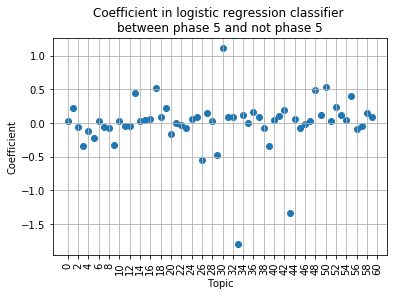

In [74]:
plt.scatter(range(len(clf.coef_[0])),clf.coef_[0])
plt.xticks(range(0,len(clf.coef_[0])+1,2),rotation=90)
plt.xlabel('Topic')
plt.ylabel('Coefficient')
plt.title('Coefficient in logistic regression classifier \nbetween phase 5 and not phase 5')
plt.grid()

In [28]:
ldamodel.show_topic(47)

[('sähkövir', 0.08063437),
 ('kytk', 0.029709047),
 ('sarj', 0.018370252),
 ('lait', 0.017849041),
 ('komponent', 0.015947282),
 ('sähkömoottor', 0.01339101),
 ('sähkölait', 0.012932554),
 ('eli', 0.0125470385),
 ('raken', 0.012349038),
 ('laite', 0.0113198925)]

In [188]:
np.std(clf.coef_[0])

0.3111038067516104

In [189]:
np.mean(clf.coef_[0])

0.0005360692171084533

In [110]:
X_train,y_train = get_topic_distribution(trainset)
X_test,y_test = get_topic_distribution(testset)

In [80]:
len(a[0])

60

In [115]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = get_topic_distribution(trainset)#make_blobs(n_samples=1000, centers=centers, random_state=40)
#transformation = [[0.4, 0.2], [-0.4, 1.2]]
#X = np.dot(X, transformation)
pca = PCA(n_components=20)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [114]:
len(X)

1905

In [116]:
v_1 = pca.components_[0]
v_2 = pca.components_[1]

In [117]:
pca.components_

array([[-0.01142853, -0.00731208,  0.00909848, ..., -0.00595645,
        -0.00731979,  0.01270913],
       [ 0.00438504,  0.01574188, -0.00982099, ..., -0.00363591,
        -0.0088206 , -0.01543635],
       [-0.00066237,  0.00652247,  0.00300619, ..., -0.00666595,
        -0.00543397,  0.0061896 ],
       ...,
       [ 0.04354618, -0.04109778, -0.11646606, ..., -0.0322638 ,
        -0.01654347,  0.23272723],
       [-0.02016083,  0.01519194,  0.06609278, ..., -0.03702898,
         0.03868529, -0.34274174],
       [-0.03794056, -0.12599665,  0.15772072, ...,  0.02085024,
         0.05684396, -0.21580076]])

In [118]:
len(pca.components_)

20

In [20]:
Xdot = np.dot(X,pca.components_.T)

NameError: name 'pca' is not defined

In [105]:
colors = {1:'r',2:'b',3:'g',4:'y',5:'black'}


In [19]:
Xdot

NameError: name 'Xdot' is not defined

In [106]:
color_label = [colors[i] for i in y]
plt.scatter(Xdot,color=color_label)

TypeError: scatter() missing 1 required positional argument: 'y'

In [97]:
X_dot = np.array(list(map(lambda x: np.dot(v_1,x),X)))

In [106]:
plt.scatter(X_dot,Y_dot,color=)

754

In [138]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 0  0  0 49]
 [ 0  0  0 27]
 [ 1  0  8 29]
 [ 0  0  3 69]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        49
           2       0.00      0.00      0.00        27
           3       0.73      0.21      0.33        38
           5       0.40      0.96      0.56        72

   micro avg       0.41      0.41      0.41       186
   macro avg       0.28      0.29      0.22       186
weighted avg       0.30      0.41      0.28       186



C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [102]:
for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)

    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    X_dot = np.array(list(map(lambda x: np.dot(v_1,x),X)))
    Y_dot = np.array(list(map(lambda x: np.dot(v_2,x),X)))
    x_min, x_max = X_dot.min() - 1, X_dot.max() + 1
    y_min, y_max = Y_dot.min() - 1, Y_dot.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)

plt.show()

training score : 0.415 (multinomial)


ValueError: X has 2 features per sample; expecting 60

In [ ]:
lda.